# SASSIE ECCO heat budget closure

*Produced by Marie Zahn <br>
Updated January 5, 2026*

***

This notebook calculates the heat budget for one day using instantaneous snapshots and daily means of data variables.

Here we follow procedures outlined in the [ECCO tutorial](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Heat_budget_closure.html#) and this [MITgcm reference](http://mitgcm.org/download/daily_snapshot/MITgcm/doc/Heat_Salt_Budget_MITgcm.pdf) by Chakraborty & Jean-Michel Campin. In summary:

For the SASSIE LLC1080 model, we do not apply a scaling factor due to the linear free surface approximation. Accordingly, the heat budget is formulated as
\begin{equation}
\underbrace{\frac{\partial(\theta)}{\partial t}}_{G^{\theta}_\textrm{total}} = \underbrace{-\nabla_{z^{*}} \cdot(\theta\,\mathbf{v}_{res}) - \frac{\partial(\theta\,w_{res})}{\partial z^{*}}}_{G^{\theta}_\textrm{advection}}\underbrace{-({\nabla\cdot\mathbf{F}_\textrm{diff}^{\theta}})}_{G^{\theta}_\textrm{diffusion}} + \underbrace{{F}_\textrm{forc}^{\theta}}_{G^{\theta}_\textrm{forcing}}
\end{equation}

***

In [1]:
## Initalize Python libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import s3fs
import fsspec
from glob import glob

import matplotlib.pyplot as plt
from datetime import datetime
import os
from pathlib import Path
import s3fs
import boto3
import numpy as np
import pandas as pd
from pathlib import Path

import dask
from dask.distributed import Client, LocalCluster

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40105")
client

<Client: 'tcp://127.0.0.1:40105' processes=8 threads=32, memory=123.95 GiB>

Task exception was never retrieved
future: <Task finished name='Task-1000' coro=<Client._gather.<locals>.wait() done, defined at /home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1013' coro=<Client._gather.<locals>.wait() done, defined at /home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1025' coro=<Client._gather.<locals>.wait(

# load sassie fields

### Open geometry file for HH

In [4]:
# First open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

In [ ]:
HH_grid

### Open `THETA` snapshots

In [6]:
def get_aws_credentials(profile_name='sassie'):
    session = boto3.Session(profile_name=profile_name)
    credentials = session.get_credentials()
    return credentials

In [17]:
def open_s3_zarr_ds(zarr_store_name):
    
    # load sassie profile credentials
    aws_credentials = get_aws_credentials(profile_name='sassie')
        
    # initialize s3 filesystem
    s3_options = dict(anon=False, key=aws_credentials.access_key, secret=aws_credentials.secret_key)
    s3 = s3fs.S3FileSystem(**s3_options)
    
    # file_s3_path = "s3://ecco-processed-data/SASSIE/N1/HH/NETCDF_COLLECTIONS_PODAAC/"
    # file_s3_path = "s3://podaac-dev-sassie/ECCO_model/model_processed_data/V1R1/HH/NETCDF"
    base_s3_path = "s3://podaac-dev-sassie/ECCO_model/N1/V1R1/HH/ZARR"

    # for netcdfs
    # file_s3_open = s3.open(file_s3_path + file_path_subdir_and_name)
    # ds = xr.open_dataset(file_s3_open)

    # for zarr store
    # create a Zarr mapper
    zarr_path = f"{base_s3_path}/{zarr_store_name}"
    store = s3fs.S3Map(root=zarr_path, s3=s3, check=False)
    
    # open the Zarr dataset
    ds = xr.open_zarr(store, consolidated=True)
    
    return ds

In [18]:
theta_ds = open_s3_zarr_ds("THETA_AVG_DAILY.ZARR/")

In [27]:
theta_mon = theta_ds.isel(k=0).THETA.resample(time="MS").mean()

In [31]:
theta_mon_arctic = theta_mon.mean(["j","i"]).load()

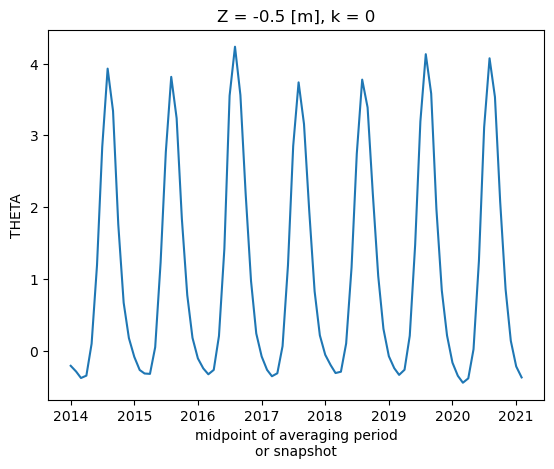

In [32]:
theta_mon_arctic.plot();

### Take first two snapshots to bookend the first daily mean timestep

In [ ]:
# Select first two snaps
theta_daily_snaps = theta_snaps.isel(time=slice(0,2))

In [ ]:
# check dates
theta_daily_snaps.time.values

In [ ]:
# check time bounds
theta_daily_snaps.time_bnds.values

### Volume

Calculate the volume of each grid cell. This is used when converting advective and diffusive flux convergences and calculating volume-weighted averages.

In [ ]:
# Volume (m^3)
# Multiply area, grid cell thickness, and land mask
mask = HH_grid.maskC.where(HH_grid.maskC,np.nan,1)
vol_sassie = ((HH_grid.rAc*HH_grid.drF)*mask).transpose('k','j','i')

In [ ]:
# (vol_sassie.isel(k=0)/1e9).plot();

### Open 3D model fields

In [ ]:
# open all datasets needed for heat budget
ADVx_TH_ds = open_s3_mfdataset('ADVx_TH_AVG_DAILY', s3_bucket='s3://ecco-processed-data/SASSIE/N1_test/HH/NETCDF')
ADVy_TH_ds = open_s3_mfdataset('ADVy_TH_AVG_DAILY', s3_bucket='s3://ecco-processed-data/SASSIE/N1_test/HH/NETCDF')
ADVr_TH_ds = open_s3_mfdataset('ADVr_TH_AVG_DAILY', s3_bucket='s3://ecco-processed-data/SASSIE/N1_test/HH/NETCDF')
DFrI_TH_ds = open_s3_mfdataset('DFrI_TH_AVG_DAILY', s3_bucket='s3://ecco-processed-data/SASSIE/N1_test/HH/NETCDF')
TFLUX_ds = open_s3_mfdataset('TFLUX_AVG_DAILY', s3_bucket='s3://ecco-processed-data/SASSIE/N1_test/HH/NETCDF')
KPPg_TH_ds = open_s3_mfdataset('KPPg_TH_AVG_DAILY', s3_bucket='s3://ecco-processed-data/SASSIE/N1_test/HH/NETCDF')
oceQsw_ds = open_s3_mfdataset('oceQsw_AVG_DAILY', s3_bucket='s3://ecco-processed-data/SASSIE/N1_test/HH/NETCDF')
WTHMASS_ds = open_s3_mfdataset('WTHMASS_AVG_DAILY', s3_bucket='s3://ecco-processed-data/SASSIE/N1_test/HH/NETCDF')

In [ ]:
# DAILY mean is labeled at middle of week time period
print(ADVx_TH_ds.isel(time=0).time.values)
print(ADVx_TH_ds.isel(time=0).time_bnds.values)

### Take first daily mean since we have snapshots to bookend this time

In [ ]:
ADVx_TH_da = ADVx_TH_ds.isel(time=0).ADVx_TH
ADVy_TH_da = ADVy_TH_ds.isel(time=0).ADVy_TH
ADVr_TH_da = ADVr_TH_ds.isel(time=0).ADVr_TH
DFrI_TH_da = DFrI_TH_ds.isel(time=0).DFrI_TH
TFLUX_da = TFLUX_ds.isel(time=0).TFLUX
KPPg_TH_da = KPPg_TH_ds.isel(time=0).KPPg_TH
oceQsw_da = oceQsw_ds.isel(time=0).oceQsw
WTHMASS_da = WTHMASS_ds.isel(time=0).WTHMASS

In [ ]:
# double check dates
print(f"snapshot start and end: {theta_daily_snaps.time.values}")
print(f"\ndaily mean time: {TFLUX_da.time.values}")
print(f"\ndaily mean time start and end: {TFLUX_ds.isel(time=0).time_bnds.values}")

***

# Calculate total tendency of $\theta$ ($G^{\theta}_\textrm{total}$)

We calculate the daily-averaged time tendency of ``THETA`` by differencing daily ``THETA`` snapshots.

In [ ]:
# Set eta term to zero due to linear free surface
sTHETA = theta_daily_snaps.THETA

In [ ]:
# Total tendency (degC/s)
G_total_diff = sTHETA.diff(dim='time').isel(time=0)
G_total_diff.name = 'G_total'

Now convert $\Delta$ `THETA` / $\Delta$ t (day) to $\Delta$ `THETA` / $\Delta$ t (seconds) by dividing by the number of seconds in a day.

In [ ]:
# number of seconds in a day
secs_per_snap = 86400

In [ ]:
# Total tendency
G_total = G_total_diff / secs_per_snap

### plot surface (k=0)

In [ ]:
Z = G_total.isel(k=0).Z.values

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
G_total.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5);
Z = G_total.isel(k=0).Z.values
ax1.set_title(f"Total temperature tendency on {str(theta_daily_snaps.time.values[0])[0:10]} from snapshots\nZ={Z} [m], surface (deg C/s)");
plt.tight_layout()

### plot 55 m

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
G_total.isel(k=16).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5);
Z = G_total.isel(k=16).Z.values
ax1.set_title(f"Total temperature tendency on {str(theta_daily_snaps.time.values[0])[0:10]} from snapshots\nZ={int(Z)} [m], surface (deg C/s)");
plt.tight_layout()

# Calculate tendency due to advective convergence ($G^{\theta}_\textrm{advection}$)
### Horizontal convergence of advective heat flux
The relevant fields from the diagnostic output here are
- `ADVx_TH`: U Component Advective Flux of Potential Temperature (degC m^3/s)
- `ADVy_TH`: V Component Advective Flux of Potential Temperature (degC m^3/s)

In [ ]:
def diff_2d_flux_HH(flux_vector_dict):
    """
    A function (similar to xgcm.Grid.diff_2d_vector) that differences flux variables on the HH Arctic grid.
    """

    u_flux = flux_vector_dict['X']
    v_flux = flux_vector_dict['Y']

    # take differences
    diff_u_flux = u_flux.diff('i_g')
    diff_v_flux = v_flux.diff('j_g')
    
    diff_u_flux_padded = diff_u_flux.pad(pad_width={'i_g':(1,0)},mode='constant',constant_values=np.nan)
    diff_v_flux_padded = diff_v_flux.pad(pad_width={'j_g':(1,0)},mode='constant',constant_values=np.nan)

    # include coordinates of input DataArrays and correct dimension/coordinate names
    diff_u_flux = diff_u_flux_padded.assign_coords(u_flux.coords).rename({'i_g':'i'})
    diff_v_flux = diff_v_flux_padded.assign_coords(v_flux.coords).rename({'j_g':'j'})

    diff_flux_vector_dict = {'X':diff_u_flux,'Y':diff_v_flux}

    return diff_flux_vector_dict

In [ ]:
# Set fluxes on land to zero (instead of NaN)
ADVx_TH = ADVx_TH_da.where(HH_grid.hFacW.values > 0,0)
ADVy_TH = ADVy_TH_da.where(HH_grid.hFacS.values > 0,0)

# Difference of horizontal components of divergence
ADVxy_diff = diff_2d_flux_HH({'X': ADVx_TH.load(), \
                              'Y': ADVy_TH.load()})

In [ ]:
# Convergence of horizontal advection (degC m^3/s)
adv_hConvH_m3 = (-(ADVxy_diff['X'] + ADVxy_diff['Y']))

# divide by volume to get degC/s
adv_hConvH = adv_hConvH_m3 / vol_sassie

### Plot horizontal convergence at the surface

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
adv_hConvH.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5);
ax1.set_title("Temperature tendency due to horizontal advective flux convergence\nk=0, surface (deg C/s)");
plt.tight_layout()

### Vertical convergence of advective heat flux
The relevant field from the diagnostic output is
- `ADVr_TH`: Vertical Advective Flux of Potential Temperature (degC m^3/s)

In [ ]:
# Pad the bottom
ADVr_TH_padded = ADVr_TH_da.pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=np.nan)

In [ ]:
# check padding
# ADVr_TH_padded.isel(k_l=-1,i=0).values

In [ ]:
# Take differences to get convergence of vertical advection (degC m^3/s)
ADVz_diff = ADVr_TH_padded.diff('k_l').compute()

In [ ]:
# change dim name
adv_vert_convergence = ADVz_diff.assign_coords(ADVr_TH_da.coords).rename({'k_l':'k'})

# divide by vol to get degC/s
adv_vert_div = (adv_vert_convergence/vol_sassie).compute()

### Plot the surface

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
adv_vert_div.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5);
ax1.set_title("Temperature tendency due to vertical advective flux convergence \nk=0, surface (deg C/s)")
plt.tight_layout()

### Total convergence of advective flux ($G^{\theta}_\textrm{advection}$)
We can get the total convergence by simply adding the horizontal and vertical component. 

In [ ]:
# Sum horizontal and vertical convergences
G_advection = (adv_hConvH + adv_vert_div).compute()

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
G_advection.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-5e-6,vmax=5e-6);
ax1.set_title("Temperature tendency due to advective flux convergence\nk=0, surface (deg C/s)")
plt.tight_layout()

# Calculate tendency due to diffusive convergence ($G^{\theta}_\textrm{diffusion}$)
### Horizontal convergence of diffusive heat flux

**There is no horizontal diffusion for the sassie model**

### Vertical convergence of diffusive heat flux
The relevant fields from the diagnostic output are
- `DFrE_TH`: Vertical Diffusive Flux of Potential Temperature (Explicit part) (degC m^3/s)
- `DFrI_TH`: Vertical Diffusive Flux of Potential Temperature (Implicit part) (degC m^3/s)
> **Note**: Vertical diffusion has both an explicit (`DFrE_TH`) and an implicit (`DFrI_TH`) part.

**There is no explicit diffusion in the sassie model**

In [ ]:
# Set fluxes on land to zero (instead of NaN)
DFrI_TH = DFrI_TH_da.where(HH_grid.hFacC.values > 0,0)
DFrI_TH = DFrI_TH.transpose('k_l','j','i')

In [ ]:
# Pad the bottom
DFrI_TH_padded = DFrI_TH.pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=np.nan)

In [ ]:
# check padding
# DFrI_TH_padded.isel(k_l=-1,i=0).values

In [ ]:
# Take differences to get convergence of vertical advection (degC m^3/s)
DFrI_TH_diff = DFrI_TH_padded.diff('k_l').compute()

In [ ]:
# change dim name
difI_vert_convergence = DFrI_TH_diff.assign_coords(DFrI_TH.coords).rename({'k_l':'k'})

# divide by vol to get degC/s
G_diffusion = (difI_vert_convergence / vol_sassie).compute()

### Total convergence of diffusive flux ($G^{\theta}_\textrm{diffusion}$)

This model uses KPP, so we need to add tendency due to KPP non-local term to the above diffusion tendency

In [ ]:
# Set fluxes on land to zero (instead of NaN)
KPPg_TH = KPPg_TH_da.where(HH_grid.hFacC.values > 0,0)
# KPPg_TH = KPPg_TH.transpose('k_l','j','i')
KPPg_TH = KPPg_TH.transpose('k','j','i')

In [ ]:
# Pad the bottom
# KPPg_TH_padded = KPPg_TH.pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=np.nan)
KPPg_TH_padded = KPPg_TH.pad(pad_width={'k':(0,1)},mode='constant',constant_values=np.nan)

In [ ]:
# check padding
# KPPg_TH_padded.isel(k_l=-1,i=0).values

In [ ]:
# Take differences to get convergence of vertical advection (degC m^3/s)
# KPPg_TH_diff = KPPg_TH_padded.diff('k_l').compute()
KPPg_TH_diff = KPPg_TH_padded.diff('k').compute()

In [ ]:
# change dim name
# KPPg_TH_convergence = KPPg_TH_diff.assign_coords(KPPg_TH_da.coords).rename({'k_l':'k'})
KPPg_TH_convergence = KPPg_TH_diff.assign_coords(KPPg_TH_da.coords).rename({'k':'k'})

# divide by vol to get degC/s
KPP_tend = (KPPg_TH_convergence / vol_sassie).compute()

In [ ]:
# for sassie, it is just vertical diffusion
G_diffusion_KPP = G_diffusion + KPP_tend
# G_diffusion_KPP = G_diffusion

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
G_diffusion.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5);
ax1.set_title("Temperature tendency due to diffusive flux convergence\nk=0, surface (deg C/s)")
plt.tight_layout()

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
G_diffusion_KPP.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5);
ax1.set_title("Temperature tendency due to diffusive flux convergence and KPP mixing\nk=0, surface (deg C/s)")
plt.tight_layout()

# Surface correction
Tendency of mass correction at the surface (due to Linear Free Surface approximation)

`tsurfcor` = 0 because `linFSConserveTr = True` was not specified in the 'data' namelist file in &PARM01. According to the MITgcm defaults listed [here](https://github.com/MITgcm/MITgcm/blob/master/model/src/set_defaults.F), linFSConserveTr = .FALSE. by default.

UNITS check:<br>
WTHMASS is in degC m s-1<br>
degC m s-1 / m = degC s-1

In [ ]:
tsurfcor = 0
Surf_corr_tend = (tsurfcor - WTHMASS_da) / HH_grid.drF.isel(k=0) * HH_grid.hFacC.isel(k=0)

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
Surf_corr_tend.plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5);
# Surf_corr_tend.plot(ax=ax1,cmap='RdBu_r',vmin=-1e-12,vmax=1e-12);
ax1.set_title("Tendency of mass correction at the surface (deg C/s)")
plt.tight_layout()

# Calculate tendency due to forcing ($G^{\theta}_\textrm{forcing}$)
Finally, we evaluate the local forcing term due to surface heat and geothermal fluxes.

### Surface heat flux
For the surface contribution, there are two relevant model diagnostics:
- `TFLUX`: total heat flux (match heat-content variations) (W/m^2)
- `oceQsw`: net Short-Wave radiation (+=down) (W/m^2)

In [ ]:
# Seawater density (kg/m^3)
# needed to convert surface mass fluxes to volume fluxes
rhoconst_sassie = 1027.5

# Heat capacity (J/(kg degC))
c_p_sassie = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

In [ ]:
Z = HH_grid.Z.compute()
RF = np.concatenate([HH_grid.Zp1.values[:-1],[np.nan]])

In [ ]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [ ]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [ ]:
# Create xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

In [ ]:
## Land masks
# Make copy of hFacC
mskC = HH_grid.hFacC.copy(deep=True).compute()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [ ]:
# Shortwave flux below the surface (W/m^2)
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw_da).transpose('k','j','i')

In [ ]:
# Surface heat flux convergence into the uppermost grid cell (W/m^2)
forcH_surf = ((TFLUX_da - (1-(q1[0]-q2[0]))*oceQsw_da)\
              *mskC[0]).transpose('j','i').assign_coords(k=0).expand_dims('k')

In [ ]:
# Full-depth sea surface forcing (W/m^2)
forcH = xr.concat([forcH_surf,forcH_subsurf[1:,:,:]], dim='k').transpose('k','j','i')

***

#### Alternate approach to calculating forcing that directly reflects [MITgcm reference](http://mitgcm.org/download/daily_snapshot/MITgcm/doc/Heat_Salt_Budget_MITgcm.pdf).

Tendency due to shortwave penetration:

In [ ]:
depth = HH_grid.Zp1.values[:-1] # equivalent to RF
depth1 = HH_grid.Zp1.values[1:]

In [ ]:
# check values
print(depth[0])
print(depth1[0])

In [ ]:
swfrac = 0.62*np.exp(depth/0.6) + (1.0-0.62)*np.exp(depth/20)
swfrac1 = 0.62*np.exp(depth1/0.6) + (1.0-0.62)*np.exp(depth1/20.0)

In [ ]:
# 3D field
Qsw_tend = oceQsw_da/(rhoconst_sassie*c_p_sassie)/(HH_grid.drF*HH_grid.hFacC)*(swfrac-swfrac1)

Tendency at surface due to incident heat flux:

In [ ]:
# 2D field for the surface
Tflx_tend = (TFLUX_da-oceQsw_da)/(rhoconst_sassie*c_p_sassie*HH_grid.drF.isel(k=0)*HH_grid.hFacC.isel(k=0))

***

### Total forcing ($G^{\theta}_\textrm{forcing}$)

In [ ]:
# convert from W/m^2 to degC/s
G_forcing = ((forcH/(rhoconst_sassie*c_p_sassie))/(HH_grid.hFacC*HH_grid.drF)).compute()

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
G_forcing.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5);
ax1.set_title(f"Temperature tendency due to surface heat and geothermal forcing\n{str(theta_daily_snaps.time.values[0])[0:10]}\nk=0, surface (deg C/s)")
plt.tight_layout()

# Budget closure

***

## First use approach outlined in MITgcm documentation that separates the surface and subsurface

#### Just the surface layer

In [ ]:
print(G_advection.isel(k=0).shape)
print(G_diffusion.isel(k=0).shape)
print(KPP_tend.isel(k=0).shape)
print(Surf_corr_tend.shape)

# print(Tflx_tend.shape)
# print(Qsw_tend.isel(k=0).shape)

In [ ]:
surf_heat_tend = G_advection.isel(k=0) + G_diffusion.isel(k=0) + Qsw_tend.isel(k=0) + Tflx_tend + Surf_corr_tend + KPP_tend.isel(k=0)

In [ ]:
res_surface = surf_heat_tend-G_total.isel(k=0)

In [ ]:
res_surface.plot(cmap='RdBu_r',vmin=-1e-5,vmax=1e-5,figsize=[9,5]);

#### Below the surface layer

In [ ]:
KPP_tend.isel(k=slice(1,90)).shape

In [ ]:
sub_surf_heat_tend = G_advection.isel(k=slice(1,90)) + G_diffusion.isel(k=slice(1,90)) + Qsw_tend.isel(k=slice(1,90)) + KPP_tend.isel(k=slice(1,90))

In [ ]:
res_sub_surface = sub_surf_heat_tend-G_total.isel(k=slice(1,90)).values

In [ ]:
res_sub_surface.isel(k=3).Z.values

In [ ]:
res_sub_surface.isel(k=3).plot(cmap='RdBu_r',vmin=-1e-5,vmax=1e-5,figsize=[9,5]);

In [ ]:
res_sub_surface.isel(k=29).Z.values

In [ ]:
res_sub_surface.isel(k=29).plot(cmap='RdBu_r',vmin=-1e-5,vmax=1e-5,figsize=[9,5]);

***

## Now use approach in ECCO documentation

In [ ]:
# double check dims
print(G_advection.shape)
print(G_diffusion.shape)
print(KPP_tend.shape)
print(G_forcing.shape)
print(Surf_corr_tend.shape)

In [ ]:
# Sum of terms in RHS of equation
rhs_sassie = G_advection + G_diffusion + G_forcing + KPP_tend
rhs_sassie_noKPP = G_advection + G_diffusion + G_forcing

In [ ]:
rhs_sassie.shape

Next add the surface correction to k=0

### RHS without surface correction

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
rhs_sassie.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5);
ax1.set_title("RHS (G_advection + G_diffusion + KPP + G_forcing)\nk=0, surface (deg C/s)")
plt.tight_layout()

### RHS with surface correction

In [ ]:
print(rhs_sassie[0, 1, 0:10].values)

In [ ]:
# Add the Surf_corr_tend 1080x1800 DataArray to the top level of the (90, 1080, 1800) ds
rhs_sassie[0, :, :] += Surf_corr_tend.load()

In [ ]:
print(rhs_sassie[0, 1, 0:10].values)

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[10,6])
rhs_sassie.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5);
ax1.set_title("RHS (G_advection + G_diffusion + KPP + G_forcing + Surf_corr_tend)\nk=0, surface (deg C/s)")
plt.tight_layout()

## Residuals

In [ ]:
print(rhs_sassie.shape)
print(G_total.shape)

In [ ]:
# calculate residuals across all vertical levels
res_sassie = (rhs_sassie-G_total).compute()
# for comparison, calculate without KPP
res_sassie_noKPP = (rhs_sassie_noKPP-G_total).compute()

### Plot residuals at the surface

Colored points mark locations for vertical profiles plotted below

In [ ]:
res_sassie.isel(k=0).plot(cmap='RdBu_r',vmin=-1e-5,vmax=1e-5,figsize=[9,5]);

# add points for locations where vertical profiles were plotted below
plt.scatter(900,600,c='tab:green');
plt.scatter(700,500,c='tab:blue');
plt.scatter(170,600,c='y');
plt.scatter(100,200,c='orange');
plt.scatter(1650,500,c='tab:red');
plt.title("SASSIE ECCO Residuals at the surface");

In [ ]:
res_sassie.isel(k=0).plot(cmap='RdBu_r',vmin=-1e-10,vmax=1e-10,figsize=[9,5]);

# add points for locations where vertical profiles were plotted below
plt.scatter(900,600,c='tab:green');
plt.scatter(700,500,c='tab:blue');
plt.scatter(170,600,c='y');
plt.scatter(100,200,c='orange');
plt.scatter(1650,500,c='tab:red');
plt.title("SASSIE ECCO Residuals at the surface (at scale of 1e-10)");

### Plot residuals at 250 m

In [ ]:
res_sassie.isel(k=30).plot(cmap='RdBu_r',vmin=-1e-10,vmax=1e-10,figsize=[9,5]);

# add points for locations where vertical profiles were plotted below
plt.scatter(900,600,c='tab:green');
plt.scatter(700,500,c='tab:blue');
plt.scatter(170,600,c='y');
plt.scatter(100,200,c='orange');
plt.scatter(1650,500,c='tab:red');
plt.title("SASSIE Residuals at 250 m");

### Plot residuals at several depths

In [ ]:
print(res_sassie.isel(k=0).Z.values)
print(res_sassie.isel(k=6).Z.values)
print(res_sassie.isel(k=30).Z.values)
print(res_sassie.isel(k=39).Z.values)
print(res_sassie.isel(k=43).Z.values)
print(res_sassie.isel(k=51).Z.values)

In [ ]:
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=[16,15])

res_sassie.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5) # 0 m
res_sassie.isel(k=6).plot(ax=ax2,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5) # 10 m
res_sassie.isel(k=30).plot(ax=ax3,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5) # 250 m
res_sassie.isel(k=39).plot(ax=ax4,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5) # 500 m
res_sassie.isel(k=43).plot(ax=ax5,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5) # 650 m
res_sassie.isel(k=51).plot(ax=ax6,cmap='RdBu_r',vmin=-1e-5,vmax=1e-5) # 1000 m

# add points for locations where vertical profiles were plotted below
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.scatter(900,600,c='tab:green')
    ax.scatter(700,500,c='tab:blue')
    ax.scatter(170,600,c='y')
    ax.scatter(100,200,c='orange')
    ax.scatter(1650,500,c='tab:red')

ax1.set_title("Residuals at 0 m")
ax2.set_title("Residuals at 10 m")
ax3.set_title("Residuals at 250 m")
ax4.set_title("Residuals at 500 m")
ax5.set_title("Residuals at 650 m")
ax6.set_title("Residuals at 1000 m");

plt.tight_layout()

#### Smaller colorbar range

In [ ]:
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=[16,15])

res_sassie.isel(k=0).plot(ax=ax1,cmap='RdBu_r',vmin=-1e-10,vmax=1e-10) # 0 m
res_sassie.isel(k=6).plot(ax=ax2,cmap='RdBu_r',vmin=-1e-10,vmax=1e-10) # 10 m
res_sassie.isel(k=30).plot(ax=ax3,cmap='RdBu_r',vmin=-1e-10,vmax=1e-10) # 250 m
res_sassie.isel(k=39).plot(ax=ax4,cmap='RdBu_r',vmin=-1e-10,vmax=1e-10) # 500 m
res_sassie.isel(k=43).plot(ax=ax5,cmap='RdBu_r',vmin=-1e-10,vmax=1e-10) # 650 m
res_sassie.isel(k=51).plot(ax=ax6,cmap='RdBu_r',vmin=-1e-10,vmax=1e-10) # 1000 m

# add points for locations where vertical profiles were plotted below
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.scatter(900,600,c='tab:green')
    ax.scatter(700,500,c='tab:blue')
    ax.scatter(170,600,c='y')
    ax.scatter(100,200,c='orange')
    ax.scatter(1650,500,c='tab:red')

ax1.set_title("Residuals at 0 m")
ax2.set_title("Residuals at 10 m")
ax3.set_title("Residuals at 250 m")
ax4.set_title("Residuals at 500 m")
ax5.set_title("Residuals at 650 m")
ax6.set_title("Residuals at 1000 m");

plt.tight_layout()

plt.savefig("sassie-ecco-residuals.png", dpi=100)

### Plot vertical profiles of residuals

In [ ]:
res_sassie_depth = res_sassie.swap_dims({'k':'Z'})
res_sassie_depth_noKPP = res_sassie_noKPP.swap_dims({'k':'Z'})

In [ ]:
# plot some profiles
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[8,6])

res_sassie_depth.isel(i=900,j=600).plot(ax=ax1,y='Z',c='tab:green',label='under ice');
res_sassie_depth.isel(i=700,j=500).plot(ax=ax1,y='Z',c='tab:blue',label='under ice');
res_sassie_depth.isel(i=170,j=600).plot(ax=ax1,y='Z',c='y',label='open water');
res_sassie_depth.isel(i=100,j=200).plot(ax=ax1,y='Z',c='orange',label='open water');
res_sassie_depth.isel(i=1650,j=500).plot(ax=ax1,y='Z',c='tab:red',label='open water');
ax1.axhline(y=0,c='k',linestyle='dashed',linewidth=0.5)
ax1.set_ylim(-4000,100);
ax1.set_title("Residuals\nfull profiles");
ax1.legend()

res_sassie_depth.isel(i=900,j=600).plot(ax=ax2,y='Z',c='tab:green');
res_sassie_depth.isel(i=700,j=500).plot(ax=ax2,y='Z',c='tab:blue');
res_sassie_depth.isel(i=170,j=600).plot(ax=ax2,y='Z',c='y');
res_sassie_depth.isel(i=100,j=200).plot(ax=ax2,y='Z',c='orange');
res_sassie_depth.isel(i=1650,j=500).plot(ax=ax2,y='Z',c='tab:red');
ax2.axhline(y=0,c='k',linestyle='dashed',linewidth=0.5)
ax2.set_ylim(-30,1);
ax2.set_title("Residuals\nupper 30 m");

res_sassie_depth_noKPP.isel(i=900,j=600).plot(ax=ax3,y='Z',c='tab:green');
res_sassie_depth_noKPP.isel(i=700,j=500).plot(ax=ax3,y='Z',c='tab:blue');
res_sassie_depth_noKPP.isel(i=170,j=600).plot(ax=ax3,y='Z',c='y');
res_sassie_depth_noKPP.isel(i=100,j=200).plot(ax=ax3,y='Z',c='orange');
res_sassie_depth_noKPP.isel(i=1650,j=500).plot(ax=ax3,y='Z',c='tab:red');
ax3.axhline(y=0,c='k',linestyle='dashed',linewidth=0.5)
ax3.set_ylim(-30,1);
ax3.set_title("Residuals without KPP\nupper 30 m");

plt.tight_layout()

In [ ]:
# plot some profiles
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[8,6])

res_sassie_depth.isel(i=900,j=600).plot(ax=ax1,y='Z',c='tab:green',label='under ice');
res_sassie_depth.isel(i=700,j=500).plot(ax=ax1,y='Z',c='tab:blue',label='under ice');
res_sassie_depth.isel(i=170,j=600).plot(ax=ax1,y='Z',c='y',label='open water');
res_sassie_depth.isel(i=100,j=200).plot(ax=ax1,y='Z',c='orange',label='open water');
res_sassie_depth.isel(i=1650,j=500).plot(ax=ax1,y='Z',c='tab:red',label='open water');
ax1.axhline(y=0,c='k',linestyle='dashed',linewidth=0.5)
ax1.set_ylim(-4000,100);
ax1.set_title("Residuals\nfull profiles");
ax1.legend()

res_sassie_depth.isel(i=900,j=600).plot(ax=ax2,y='Z',c='tab:green');
res_sassie_depth.isel(i=700,j=500).plot(ax=ax2,y='Z',c='tab:blue');
res_sassie_depth.isel(i=170,j=600).plot(ax=ax2,y='Z',c='y');
res_sassie_depth.isel(i=100,j=200).plot(ax=ax2,y='Z',c='orange');
res_sassie_depth.isel(i=1650,j=500).plot(ax=ax2,y='Z',c='tab:red');
ax2.axhline(y=0,c='k',linestyle='dashed',linewidth=0.5)
ax2.set_ylim(-500,1);
ax2.set_title("Residuals\nupper 500 m");

res_sassie_depth_noKPP.isel(i=900,j=600).plot(ax=ax3,y='Z',c='tab:green');
res_sassie_depth_noKPP.isel(i=700,j=500).plot(ax=ax3,y='Z',c='tab:blue');
res_sassie_depth_noKPP.isel(i=170,j=600).plot(ax=ax3,y='Z',c='y');
res_sassie_depth_noKPP.isel(i=100,j=200).plot(ax=ax3,y='Z',c='orange');
res_sassie_depth_noKPP.isel(i=1650,j=500).plot(ax=ax3,y='Z',c='tab:red');
ax3.axhline(y=0,c='k',linestyle='dashed',linewidth=0.5)
ax3.set_ylim(-500,1);
ax3.set_title("Residuals without KPP\nupper 500 m");

plt.tight_layout()

### Histogram of residuals

#### Surface

In [ ]:
res_sassie_ravel = np.abs(res_sassie.isel(k=0).values.ravel())

In [ ]:
res_sassie_ravel.shape

In [ ]:
plt.figure(figsize=(10,3));
plt.hist(res_sassie_ravel[res_sassie_ravel > 0],np.linspace(0, 1e-10, 200));
plt.grid()

#### Below 2000 m

In [ ]:
res_sassie.isel(k=67).Z.values

In [ ]:
# select residuals below 2000 m
res_sassie_below2000 = res_sassie.isel(k=slice(67,90))

In [ ]:
res_sassie_below2000_ravel = np.abs(res_sassie_below2000.values.ravel())

In [ ]:
res_sassie_below2000_ravel.shape

In [ ]:
plt.figure(figsize=(10,3));
plt.hist(res_sassie_below2000_ravel[res_sassie_below2000_ravel > 0],np.linspace(0, 1e-10, 200));
plt.grid()

#### All

In [ ]:
res_sassie_all_ravel = np.abs(res_sassie.values.ravel())

In [ ]:
res_sassie_all_ravel.shape

In [ ]:
plt.figure(figsize=(10,3));
plt.hist(res_sassie_all_ravel[res_sassie_all_ravel > 0],np.linspace(0, 1e-10, 200));
plt.grid()

# Plot everything together

Next we will use one `j` row (j=500) to compare each component of the heat budget

In [ ]:
res_sassie.isel(k=0).plot(cmap='RdBu_r',vmin=-1e-10,vmax=1e-10,figsize=[9,5]);

# add points for locations where vertical profiles were plotted below
plt.scatter(900,600,c='tab:green');
plt.scatter(700,500,c='tab:blue');
plt.scatter(170,600,c='y');
plt.scatter(100,200,c='orange');
plt.scatter(1650,500,c='tab:red');

plt.axhline(y=500,color='r')

plt.title("SASSIE Residuals at the surface");

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[5,4])
ax1.set_title('Heat budget for selected row\nk=0, surface (deg C/s)')

# ax1.set_title('sassie')
ax1.plot(G_total.isel(j=500,k=0),label='G_total')
ax1.plot(rhs_sassie.isel(j=500,k=0),label='RHS')
ax1.plot(res_sassie.isel(j=500,k=0),label='Residual')

ax1.set_xlabel("i")
ax1.axhline(y=0,color='k',linewidth=0.5,linestyle='dashed');

ax1.set_ylim(-6e-5,6e-5)
ax1.set_ylabel('$\degree$C s$^{-1}$')
# ax1.set_xlim(0,400)
# ax2.set_xlim(0,33)
plt.tight_layout()
ax1.legend();

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[5,4])
ax1.set_title('Heat budget for selected row\nk=0, surface (deg C/s), zoomed x-axis')

# ax1.set_title('sassie')
ax1.plot(G_total.isel(j=500,k=0),label='G_total')
ax1.plot(rhs_sassie.isel(j=500,k=0),label='RHS')
ax1.plot(res_sassie.isel(j=500,k=0),label='Residual')

ax1.set_xlabel("i")
ax1.axhline(y=0,color='k',linewidth=0.5,linestyle='dashed');

ax1.set_ylim(-6e-5,6e-5)
ax1.set_xlim(250,500)
ax1.set_ylabel('$\degree$C s$^{-1}$')
# ax2.set_xlim(0,33)
plt.tight_layout()
ax1.legend();

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[8,6])
ax1.set_title('Summary showing each RHS component for selected row\nk=0, surface (deg C/s)')

# ax1.set_title('sassie')
# ax1.plot(G_total.isel(j=500,k=0),label='G_total')
ax1.plot(G_advection.isel(j=500,k=0),label='G_advection')
ax1.plot(G_diffusion.isel(j=500,k=0),label='G_diffusion')
ax1.plot(G_forcing.isel(j=500,k=0),label='G_forcing')
ax1.plot(KPP_tend.isel(j=500,k=0),label='KPP')
ax1.plot(Surf_corr_tend.isel(j=500),label='Surface Correction')

ax1.set_xlabel("i")
ax1.set_ylabel('$\degree$C s$^{-1}$')
ax1.axhline(y=0,color='k',linewidth=0.5,linestyle='dashed');

ax1.set_ylim(-4e-5,6.5e-5)
plt.tight_layout()
ax1.legend();

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[8,6])
ax1.set_title('Summary showing each RHS component for selected row\nk=0, surface (deg C/s)')

# ax1.set_title('sassie')
# ax1.plot(G_total.isel(j=500,k=0),label='G_total')
ax1.plot(G_advection.isel(j=500,k=0),label='G_advection')
ax1.plot(G_diffusion.isel(j=500,k=0),label='G_diffusion')
ax1.plot(G_forcing.isel(j=500,k=0),label='G_forcing')
ax1.plot(KPP_tend.isel(j=500,k=0),label='KPP')
ax1.plot(Surf_corr_tend.isel(j=500),label='Surface Correction')

ax1.set_xlabel("i")
ax1.set_ylabel('$\degree$C s$^{-1}$')
ax1.axhline(y=0,color='k',linewidth=0.5,linestyle='dashed');

ax1.set_ylim(-4e-5,4e-5)
ax1.set_xlim(325,500)
plt.tight_layout()
ax1.legend();

## Look at deeper grid cells at ~250 m

In [ ]:
HH_grid.isel(k=30).Z.values

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[5,4])
ax1.set_title('Heat budget for selected row\n250 m (deg C/s)')

# ax1.set_title('sassie')
ax1.plot(G_total.isel(j=500,k=30),label='G_total')
ax1.plot(rhs_sassie.isel(j=500,k=30),label='RHS')
ax1.plot(res_sassie.isel(j=500,k=30),label='Residual')

ax1.set_xlabel("i")
ax1.axhline(y=0,color='k',linewidth=0.5,linestyle='dashed');

ax1.set_ylim(-1.5e-5,1.5e-5)
ax1.set_ylabel('$\degree$C s$^{-1}$')
# ax1.set_xlim(0,400)
# ax2.set_xlim(0,33)
plt.tight_layout()
ax1.legend();

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[5,4])
ax1.set_title('Heat budget for selected row\n250 m (deg C/s), zoomed x-axis')

# ax1.set_title('sassie')
ax1.plot(G_total.isel(j=500,k=30),label='G_total')
ax1.plot(rhs_sassie.isel(j=500,k=30),label='RHS')
ax1.plot(res_sassie.isel(j=500,k=30),label='Residual')

ax1.set_xlabel("i")
ax1.axhline(y=0,color='k',linewidth=0.5,linestyle='dashed');

ax1.set_ylim(-1e-5,1e-5)
ax1.set_xlim(630,800)
ax1.set_ylabel('$\degree$C s$^{-1}$')
# ax2.set_xlim(0,33)
plt.tight_layout()
ax1.legend();

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[8,6])
ax1.set_title('Summary showing each RHS component for selected row\n250 m (deg C/s)')

# ax1.set_title('sassie')
# ax1.plot(G_total.isel(j=500,k=0),label='G_total')
ax1.plot(G_advection.isel(j=500,k=30),label='G_advection')
ax1.plot(G_diffusion.isel(j=500,k=30),label='G_diffusion')
ax1.plot(G_forcing.isel(j=500,k=30),label='G_forcing')
ax1.plot(KPP_tend.isel(j=500,k=30),label='KPP')

ax1.set_xlabel("i")
ax1.set_ylabel('$\degree$C s$^{-1}$')
ax1.axhline(y=0,color='k',linewidth=0.5,linestyle='dashed');

ax1.set_ylim(-1e-5,1.5e-5)
plt.tight_layout()
ax1.legend();

In [ ]:
fig, (ax1) = plt.subplots(1,1,figsize=[8,6])
ax1.set_title('Summary showing each RHS component for selected row\n250 m (deg C/s)')

# ax1.set_title('sassie')
# ax1.plot(G_total.isel(j=500,k=0),label='G_total')
ax1.plot(G_advection.isel(j=500,k=30),label='G_advection')
ax1.plot(G_diffusion.isel(j=500,k=30),label='G_diffusion')
ax1.plot(G_forcing.isel(j=500,k=30),label='G_forcing')
ax1.plot(KPP_tend.isel(j=500,k=30),label='KPP')

ax1.set_xlabel("i")
ax1.set_ylabel('$\degree$C s$^{-1}$')
ax1.axhline(y=0,color='k',linewidth=0.5,linestyle='dashed');

ax1.set_ylim(-2e-6,2e-6)
ax1.set_xlim(0,175)
plt.tight_layout()
ax1.legend();

#### Vertically integrate residuals

In [ ]:
def degC_vertical_int(da, cp, rho, vol):
    """
    Converts [degC s-1] --> [J/s m3]
    Weight each grid cell by volume
    Vertically integrates (sum across 'k')
    Divides by total volume and then converts to [degC s-1]

    da : DataArray for variable with 3 dims: e.g., [k,j,i]
    cp : specific heat capacity
    rho : density
    vol : DataArray of volume for each grid cell with 3 dims [k,j,i]
    """
    
    # rename i_g and j_g
    if 'i_g' in da.dims:
        da = da.rename({'i_g':'i'})
    if 'j_g' in da.dims:
        da = da.rename({'j_g':'j'})
    if 'k_l' in da.dims:
        da = da.rename({'k_l':'k'})
        
    # Convert to J/s because we cannot sum degC/s
    # [degC s-1] x cp  [J kg-1 K-1] x rho [kg m-3] --> J/s m3
    da_joules = da * cp * rho

    # weight each grid cell by vol(k)/total vol
    # volume for entire water column for each horizontal grid cell
    vol_column = vol.sum('k').compute() 
    # divide by total water column to get weights
    vol_weights = vol / vol_column
    
    # now sum across k to get total energy change in the column
    da_joules_int = (da_joules*vol_weights).sum('k').compute()

    # then divide by total column volume
    da_joules_m3 = (da_joules_int / vol_column).compute()

    # divide by cp and rho to convert [J s-1 m-3] to [degC/s]
    da_vert_int = da_joules_m3 / cp / rho

    return da_vert_int

#### plot vertical integral of the tendency due to diffusion

In [ ]:
vert_int_diff = degC_vertical_int(G_diffusion, c_p_sassie, rhoconst_sassie, vol_sassie)
vert_int_diff_KPP = degC_vertical_int(G_diffusion_KPP, c_p_sassie, rhoconst_sassie, vol_sassie)

In [ ]:
vert_int_diff.plot(cmap='RdBu_r',vmin=-1e-16,vmax=1e-16,figsize=[9,5]);
plt.title("Vertical integral of the tendency due to diffusion ($\degree$Cs$^{-1}$)");

In [ ]:
vert_int_diff_KPP.plot(cmap='RdBu_r',vmin=-1e-16,vmax=1e-16,figsize=[9,5]);
plt.title("Vertical integral of the tendency due to diffusion with KPP ($\degree$Cs$^{-1}$)");

#### plot vertical integral of the tendency due to advection

In [ ]:
vert_int_adv = degC_vertical_int(G_advection, c_p_sassie, rhoconst_sassie, vol_sassie)

In [ ]:
vert_int_adv.plot(cmap='RdBu_r',vmin=-1e-16,vmax=1e-16,figsize=[9,5]);
plt.title("Vertical integral of the tendency due to advection ($\degree$Cs$^{-1}$)");

#### plot vertically integrated residuals

In [ ]:
# get vertical integral of residuals
res_sassie_integrated = degC_vertical_int(res_sassie, c_p_sassie, rhoconst_sassie, vol_sassie)

In [ ]:
res_sassie_integrated.plot(cmap='RdBu_r',vmin=-1e-16,vmax=1e-16,figsize=[9,5]);
plt.title("Vertically integrated residuals ($\degree$Cs$^{-1}$)");

#### Compute cumulative sum from bottom to top

In [ ]:
# Convert to J/s because we cannot sum degC/s
# [degC m3 s-1] x cp  [J kg-1 K-1] x rho [kg m-3] --> J/s
res_sassie_joules = res_sassie * c_p_sassie * rhoconst_sassie

In [ ]:
# weight each grid cell by vol(k)/total vol
# volume for entire water column for each horizontal grid cell
vol_column = vol_sassie.sum('k').compute() 
# divide by total water column to get weights
vol_weights = vol_sassie / vol_column

In [ ]:
# take cumulative sum from bottom to top
res_sassie_joules_cumsum = (res_sassie_joules*vol_weights).isel(k=slice(None, None, -1)).cumsum(dim='k')

# mask out land
res_sassie_joules_cumsum_wet = res_sassie_joules_cumsum.where(HH_grid.hFacC>0)

In [ ]:
# convert back to degC/s

# divide by volume to get [J s-1 m-3]
tmp_cumsum = res_sassie_joules_cumsum_wet.isel(k=slice(None, None, -1)) / vol_sassie

# divide by cp and rho to convert [J s-1 m-3] to [degC/s]
res_sassie_cumsum = tmp_cumsum / c_p_sassie / rhoconst_sassie

# swap dims
res_sassie_cumsum_depth = res_sassie_cumsum.swap_dims({'k':'Z'})

In [ ]:
# plot some profiles
fig, ((ax1,ax3),(ax2,ax4)) = plt.subplots(2,2,figsize=[5,8.5])

res_sassie_depth.isel(i=900,j=600).plot(ax=ax1,y='Z',c='tab:green',label='under ice');
res_sassie_depth.isel(i=1400,j=535).plot(ax=ax1,y='Z',c='tab:blue',label='MIZ');
res_sassie_depth.isel(i=1750,j=400).plot(ax=ax1,y='Z',c='tab:red',label='open water');
res_sassie_depth.isel(i=1760,j=100).plot(ax=ax1,y='Z',c='orange',label='open water');
ax1.axhline(y=0,c='k',linestyle='dashed',linewidth=0.5)
ax1.set_ylim(-4000,100);
ax1.set_title("Residuals ($\degree Cs^{-1}$)\nfull profiles");
ax1.legend()

res_sassie_depth.isel(i=900,j=600).plot(ax=ax2,y='Z',c='tab:green');
res_sassie_depth.isel(i=1400,j=535).plot(ax=ax2,y='Z',c='tab:blue');
res_sassie_depth.isel(i=1750,j=400).plot(ax=ax2,y='Z',c='tab:red');
res_sassie_depth.isel(i=1760,j=100).plot(ax=ax2,y='Z',c='orange');
ax2.axhline(y=0,c='k',linestyle='dashed',linewidth=0.5)
ax2.set_ylim(-500,20);
ax2.set_title("Residuals ($\degree Cs^{-1}$)\nupper 500 m");

# cumulative sum of residuals
res_sassie_cumsum_depth.isel(i=900,j=600).plot(ax=ax3,y='Z',c='tab:green');
res_sassie_cumsum_depth.isel(i=1400,j=535).plot(ax=ax3,y='Z',c='tab:blue');
res_sassie_cumsum_depth.isel(i=1750,j=400).plot(ax=ax3,y='Z',c='tab:red');
res_sassie_cumsum_depth.isel(i=1760,j=100).plot(ax=ax3,y='Z',c='orange');
ax3.axhline(y=0,c='k',linestyle='dashed',linewidth=0.5)
ax3.set_ylim(-4000,100);
ax3.set_title("Cumulative Sum\nof Residuals ($\degree Cs^{-1}$)");

res_sassie_cumsum_depth.isel(i=900,j=600).plot(ax=ax4,y='Z',c='tab:green');
res_sassie_cumsum_depth.isel(i=1400,j=535).plot(ax=ax4,y='Z',c='tab:blue');
res_sassie_cumsum_depth.isel(i=1750,j=400).plot(ax=ax4,y='Z',c='tab:red');
res_sassie_cumsum_depth.isel(i=1760,j=100).plot(ax=ax4,y='Z',c='orange');
ax4.axhline(y=0,c='k',linestyle='dashed',linewidth=0.5)
ax4.set_ylim(-500,20);
ax4.set_title("Cumulative Sum\nof Residuals ($\degree Cs^{-1}$)\nupper 500 m");

plt.tight_layout()